This code is an implementation of the following process:
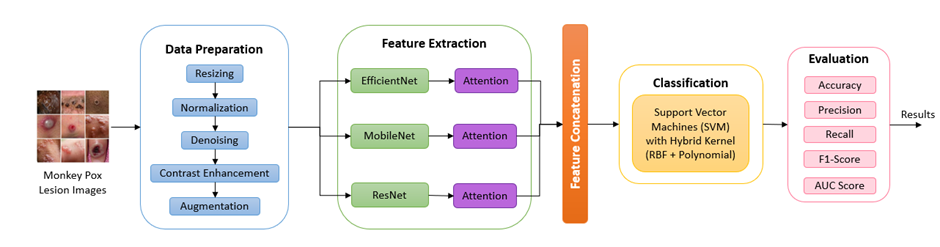

#Load the Data and Dependencies

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

# Extract Augmented Images

In [ ]:
# extract original images from the zip folder
def extract_files(zip_file_path, folder_name, extract_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.startswith(folder_name + '/'):
                file_path = os.path.join(extract_path, os.path.relpath(file_info.filename, folder_name))
                dir_path = os.path.dirname(file_path)
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)
                with open(file_path, 'wb') as f:
                    f.write(zip_ref.read(file_info.filename))

zip_file_path ='/content/drive/MyDrive/MonkeyPoxClassification_2025/dataset_files.zip'
folder_name = 'Augmented Images'
extract_path = '/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images'
extract_files(zip_file_path, folder_name, extract_path)

In [ ]:
def count_images_in_folders(folder_path):
    splits = ['Train']
    categories = ['Chickenpox', 'Cowpox', 'Healthy', 'HFMD', 'Measles', 'Monkeypox']

    for split in splits:
        split_path = os.path.join(folder_path, split)
        print(f"Split: {split}")
        for category in categories:
            category_path = os.path.join(split_path, category)
            image_count = len([file for file in os.listdir(category_path) if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))])
            print(f"  {category}: {image_count}")
        print()

# Call the function for each folder
for i in range(1,6):
  folder_path = f'/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/Augmented Images/FOLDS_AUG/fold{i}_AUG'
  print(f"FOLD{i} Details")
  count_images_in_folders(folder_path)


FOLD1 Details
Split: Train
  Chickenpox: 700
  Cowpox: 686
  Healthy: 1162
  HFMD: 1624
  Measles: 518
  Monkeypox: 2828

FOLD2 Details
Split: Train
  Chickenpox: 714
  Cowpox: 658
  Healthy: 1120
  HFMD: 1526
  Measles: 560
  Monkeypox: 2548

FOLD3 Details
Split: Train
  Chickenpox: 714
  Cowpox: 658
  Healthy: 1050
  HFMD: 1596
  Measles: 504
  Monkeypox: 3010

FOLD4 Details
Split: Train
  Chickenpox: 728
  Cowpox: 616
  Healthy: 1162
  HFMD: 1610
  Measles: 504
  Monkeypox: 2716

FOLD5 Details
Split: Train
  Chickenpox: 742
  Cowpox: 602
  Healthy: 1162
  HFMD: 1526
  Measles: 532
  Monkeypox: 2968



In [ ]:
import os
import shutil

def collate_files(src_folder, dst_folder):
    categories = ['Monkeypox', 'Chickenpox', 'Measles', 'Cowpox', 'HFMD', 'Healthy']
    splits = ['Train']

    # Create destination folders
    for split in splits:
        split_path = os.path.join(dst_folder, split)
        os.makedirs(split_path, exist_ok=True)
        for category in categories:
            category_path = os.path.join(split_path, category)
            # Ensure all necessary subdirectories are created
            os.makedirs(category_path, exist_ok=True)

    # Collate files
    for fold in range(1, 6):
        fold_path = os.path.join(src_folder, f'fold{fold}_AUG')
        for split in splits:
            split_path = os.path.join(fold_path, split)
            for category in categories:
                category_path = os.path.join(split_path, category)
                dst_category_path = os.path.join(dst_folder, split, category)
                for file in os.listdir(category_path):
                    src_file_path = os.path.join(category_path, file)
                    dst_file_path = os.path.join(dst_category_path, file)
                    shutil.copy2(src_file_path, dst_file_path)

# Replace with your source and destination folders
src_folder = '/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/Augmented Images/FOLDS_AUG'
dst_folder = '/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined'

os.makedirs(dst_folder, exist_ok=True)

collate_files(src_folder, dst_folder)

In [ ]:
# count files in Train directory of combined folder
folder_path = '/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/Train'
train_dict = {}

for category in os.listdir(folder_path):
  category_path = os.path.join(folder_path, category)
  image_count = len([file for file in os.listdir(category_path) if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))])
  print(f"  {category}: {image_count}")
  # append the information in a dict
  train_dict[category] = image_count

  Monkeypox: 3976
  Chickenpox: 1050
  Measles: 770
  Cowpox: 924
  HFMD: 2254
  Healthy: 1596


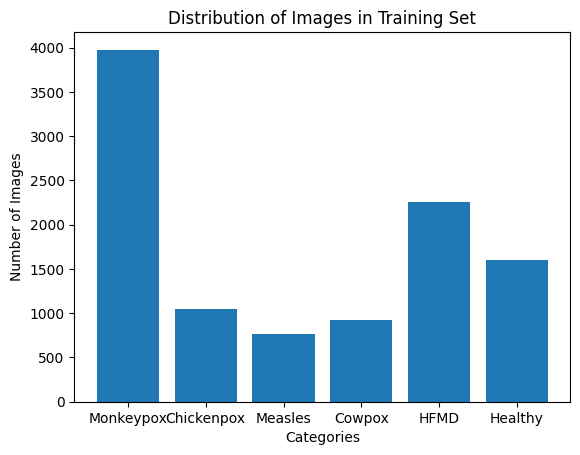

In [ ]:
import matplotlib.pyplot as plt

# plot the distribution in training set
plt.bar(list(train_dict.keys()), list(train_dict.values()))
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Training Set')
plt.show()

Here, the dataset is highly imbalanced. We need to balance it by downsampling the majority classes to 1000 and upsample minority classes to 1000.

# Random Downsampling and Augmentation

In [ ]:
! pip install augmentor

In [ ]:
# downsample all majority class to 1000
import random
import Augmentor
import shutil

def downsample_class(class_path, output_class_path, current_count):
    images = os.listdir(class_path)
    selected_images = random.sample(images, TARGET_COUNT)
    for img in selected_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_class_path, img))

def augment_class(class_name, class_path, output_class_path, current_count):
    augment_count = TARGET_COUNT - current_count

    # Setup Augmentor pipeline
    p = Augmentor.Pipeline(source_directory=class_path, output_directory=output_class_path)
    p.flip_left_right(probability=0.7)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom_random(probability=0.7, percentage_area=0.5)
    p.sample(augment_count)

    # Copy existing original images
    for img in os.listdir(class_path):
        shutil.copy(os.path.join(class_path, img), os.path.join(output_class_path, img))

def balance_dataset():
    for class_name in os.listdir(DATASET_DIR):
        class_path = os.path.join(DATASET_DIR, class_name)
        output_class_path = os.path.join(OUTPUT_DIR, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        num_images = len(os.listdir(class_path))
        print(f"{class_name}: {num_images}")

        if num_images > TARGET_COUNT:
            print(f"Downsampling {class_name} from {num_images} to {TARGET_COUNT}")
            downsample_class(class_path, output_class_path, num_images)
        elif num_images < TARGET_COUNT:
            print(f"Augmenting {class_name} from {num_images} to {TARGET_COUNT}")
            augment_class(class_name, class_path, output_class_path, num_images)
        else:
            # Exactly 1000, just copy
            for img in os.listdir(class_path):
                shutil.copy(os.path.join(class_path, img), os.path.join(output_class_path, img))

In [ ]:
TARGET_COUNT = 1000
DATASET_DIR = "/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/Train"
OUTPUT_DIR = "/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train"
os.makedirs(OUTPUT_DIR, exist_ok=True)

balance_dataset()

Monkeypox: 3976
Downsampling Monkeypox from 3976 to 1000
Chickenpox: 1050
Downsampling Chickenpox from 1050 to 1000
Measles: 770
Augmenting Measles from 770 to 1000
Initialised with 770 image(s) found.
Output directory set to /content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train/Measles.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x795E5A41D810>: 100%|██████████| 230/230 [00:01<00:00, 146.94 Samples/s]


Cowpox: 924
Augmenting Cowpox from 924 to 1000
Initialised with 924 image(s) found.
Output directory set to /content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train/Cowpox.

Processing <PIL.Image.Image image mode=RGB size=227x227 at 0x795E57146050>: 100%|██████████| 76/76 [00:00<00:00, 126.36 Samples/s]


HFMD: 2254
Downsampling HFMD from 2254 to 1000
Healthy: 1596
Downsampling Healthy from 1596 to 1000


In [ ]:
# check the distribution again
folder_path = '/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train'
train_dict = {}

for category in os.listdir(folder_path):
  category_path = os.path.join(folder_path, category)
  image_count = len([file for file in os.listdir(category_path) if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))])
  print(f"  {category}: {image_count}")
  # append the information in a dict
  train_dict[category] = image_count

  Monkeypox: 1000
  Chickenpox: 1000
  Measles: 1000
  Cowpox: 1000
  HFMD: 1000
  Healthy: 1000


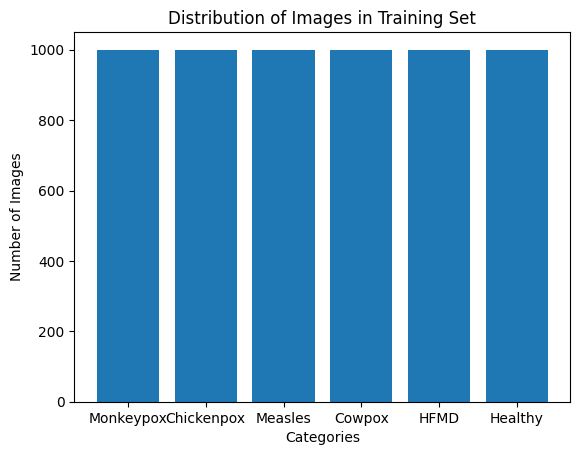

In [ ]:
# plot the distribution in training set
plt.bar(list(train_dict.keys()), list(train_dict.values()))
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Training Set')
plt.show()

Now we have equal representation of all classes.

# Data Preparation for Train

In [ ]:
!pip install --upgrade jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 87.9 MB/s eta 0:00:00
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
  Attempting uninstall: jax
    Found existing installation: jax 0.5.2
    Uninstalling jax-0.5.2:
      Successfully uninstalled jax-0.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.


In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:
# Define the data generators
datagen = ImageDataGenerator(
    )

In [ ]:
folder = '/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train'

# Create the data generators
train_generator = datagen.flow_from_directory(
    folder,
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224),
    shuffle=False  # important
)

Found 6000 images belonging to 6 classes.


In [ ]:
num_classes = train_generator.num_classes

# Feature Extraction with CBAM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.preprocessing import image
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

def cbam_block(input_feature, ratio=8):
    # Channel Attention
    channel = input_feature.shape[-1]

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)

    shared_dense_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Activation('sigmoid')(Add()([avg_out, max_out]))
    channel_refined = Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool_spatial = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool_spatial = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined)
    concat = Concatenate(axis=3)([avg_pool_spatial, max_pool_spatial])

    spatial_attention = Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid',
                               kernel_initializer='he_normal', use_bias=False)(concat)
    refined_feature = Multiply()([channel_refined, spatial_attention])

    return refined_feature


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50

# Input
inputs = Input(shape=(224, 224, 3))

# Load frozen backbones
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)
resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

mobilenet.trainable = False
efficientnet.trainable = False
resnet.trainable = False

# Apply CBAM to each model output
mobilenet_cbam = cbam_block(mobilenet.output)
efficientnet_cbam = cbam_block(efficientnet.output)
resnet_cbam = cbam_block(resnet.output)

# Pooling to reduce dimensions
mobilenet_feat = GlobalAveragePooling2D()(mobilenet_cbam)
efficientnet_feat = GlobalAveragePooling2D()(efficientnet_cbam)
resnet_feat = GlobalAveragePooling2D()(resnet_cbam)

# Combine features
merged_features = Concatenate()([mobilenet_feat, efficientnet_feat, resnet_feat])

# Feature extractor model
feature_model = Model(inputs=inputs, outputs=merged_features)

<ipython-input-8-b6b5540a1e6e>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
import numpy as np

# Number of samples
num_samples = train_generator.samples

# Pre-allocate features and labels
X_features = []
y_labels = []

# Reset the generator
train_generator.reset()

# Loop through batches
for _ in range(len(train_generator)):
    x_batch, y_batch = train_generator.__next__()
    batch_features = feature_model.predict(x_batch, verbose=0)

    X_features.append(batch_features)
    y_labels.append(y_batch)

# Stack all features and labels
X_features = np.vstack(X_features)
y_labels = np.vstack(y_labels)
y_labels = np.argmax(y_labels, axis=1)  # Convert to class indices


In [ ]:
# 3 pretrain models save the features
np.save('/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train/X_features.npy', X_features)
np.save('/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train/y_labels.npy', y_labels)

# Classification with Hybrid SVC

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# load the saved fetaures and labels
X_features = np.load('/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train/X_features.npy')
y_labels = np.load('/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train/y_labels.npy')

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.metrics import classification_report


# Define hybrid kernel
def hybrid_kernel(X, Y):
    return 0.5 * rbf_kernel(X, Y, gamma=0.015) + 0.5 * polynomial_kernel(X, Y, degree=3)

# Train SVM with hybrid kernel
svm_clf = SVC(kernel=hybrid_kernel)
svm_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=train_generator.class_indices.keys()))

              precision    recall  f1-score   support

  Chickenpox       0.90      0.89      0.90       215
      Cowpox       0.97      0.95      0.96       222
        HFMD       0.92      0.95      0.93       176
     Healthy       0.93      0.96      0.95       204
     Measles       0.92      0.91      0.92       189
   Monkeypox       0.85      0.84      0.84       194

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200



In [ ]:
# Confusion MAtrix
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict labels and decision scores
y_pred = svm_clf.predict(X_val)
y_score = svm_clf.decision_function(X_val)  # Needed for ROC curves


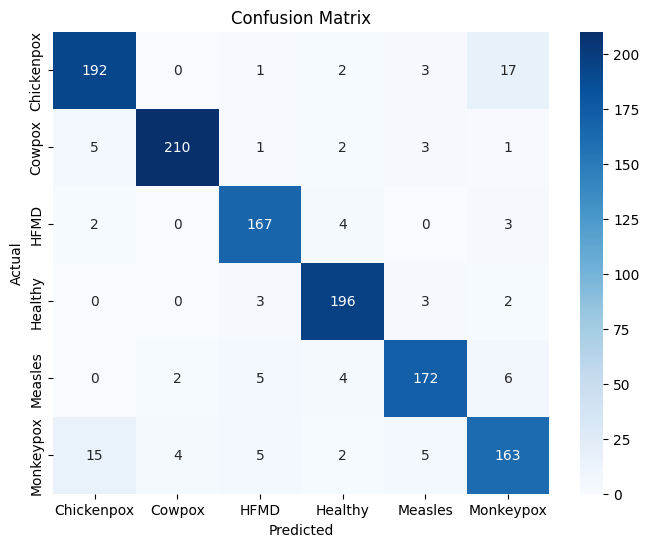

In [ ]:
# Class names
class_names = list(train_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


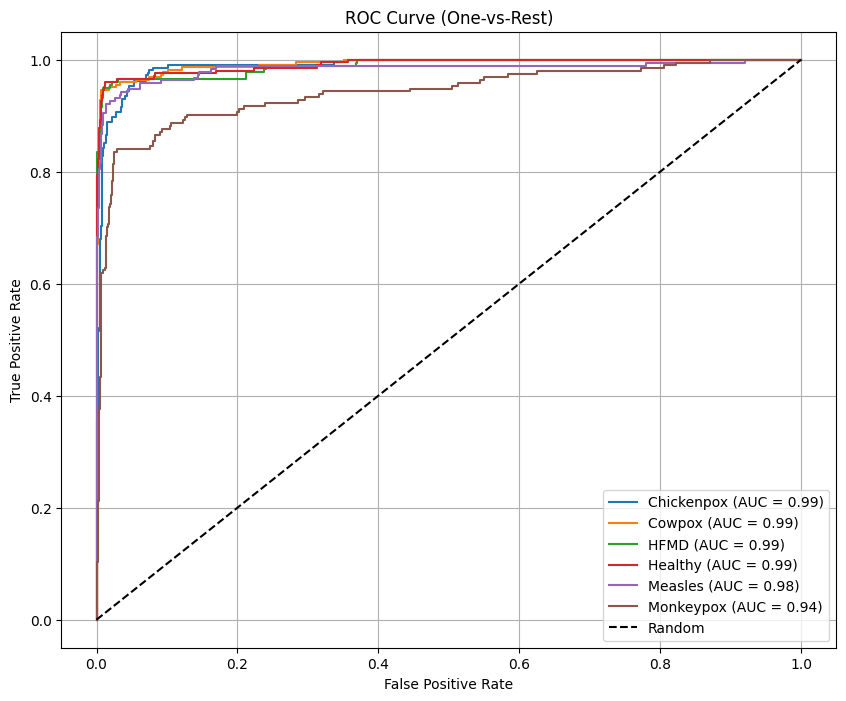

In [ ]:
# Binarize labels for one-vs-rest ROC
y_val_bin = label_binarize(y_val, classes=range(len(class_names)))

# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Performance with Individual SVM Kernels

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_svm_kernel(X_train, X_val, y_train, y_val,
                        kernel_type='rbf', kernel_params=None,
                        class_names=None):

    kernel_params = kernel_params or {}
    class_names = class_names or [str(i) for i in range(len(np.unique(y_val)))]

    print(f"\nTraining SVM with kernel = '{kernel_type}' | Params: {kernel_params}")

    # Train
    svm = SVC(kernel=kernel_type, probability=True, **kernel_params)
    svm.fit(X_train, y_train)

    # Predict
    y_pred = svm.predict(X_val)
    y_score = svm.predict_proba(X_val)

    # Accuracy
    acc = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Classification Report
    print(classification_report(y_val, y_pred, target_names=class_names))

    # ROC AUC
    y_val_bin = label_binarize(y_val, classes=range(len(class_names)))
    auc_score = roc_auc_score(y_val_bin, y_score)
    print(f"AUC: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({kernel_type} kernel)")
    plt.show()

    # ROC Curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({kernel_type} kernel)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



Training SVM with kernel = 'linear' | Params: {}
Accuracy: 0.9100
              precision    recall  f1-score   support

  Chickenpox       0.89      0.85      0.87       215
      Cowpox       0.97      0.95      0.96       222
        HFMD       0.93      0.95      0.94       176
     Healthy       0.92      0.97      0.95       204
     Measles       0.95      0.91      0.93       189
   Monkeypox       0.80      0.82      0.81       194

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200

AUC: 0.9934


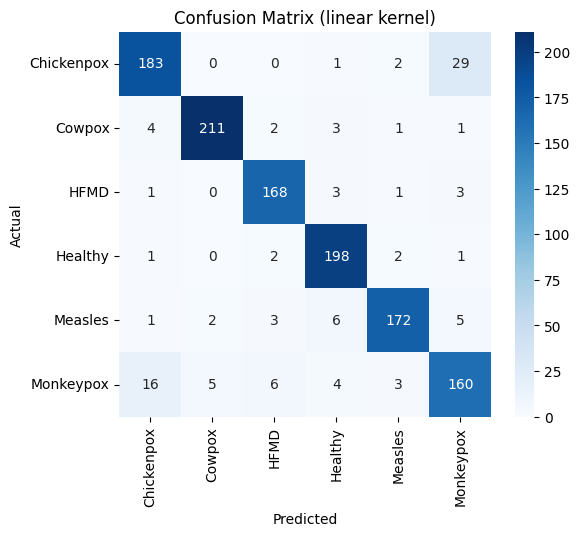

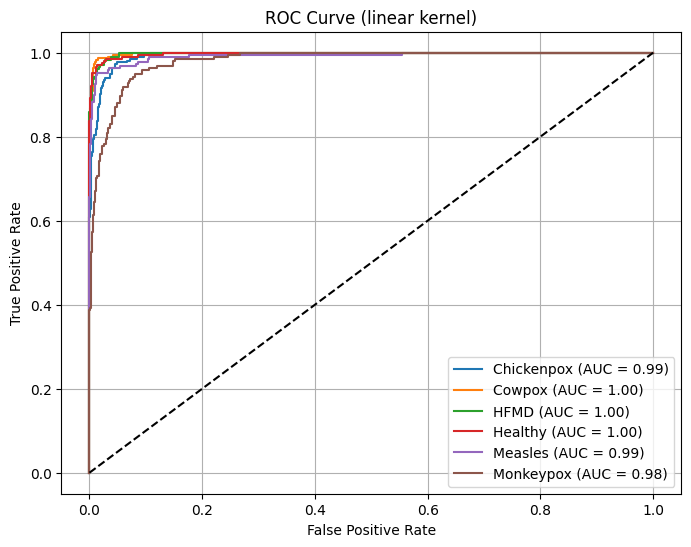


Training SVM with kernel = 'rbf' | Params: {'gamma': 0.05}
Accuracy: 0.2217
              precision    recall  f1-score   support

  Chickenpox       1.00      0.09      0.17       215
      Cowpox       1.00      0.12      0.22       222
        HFMD       0.16      1.00      0.27       176
     Healthy       1.00      0.08      0.15       204
     Measles       1.00      0.10      0.17       189
   Monkeypox       1.00      0.04      0.08       194

    accuracy                           0.22      1200
   macro avg       0.86      0.24      0.18      1200
weighted avg       0.88      0.22      0.18      1200

AUC: 0.6273


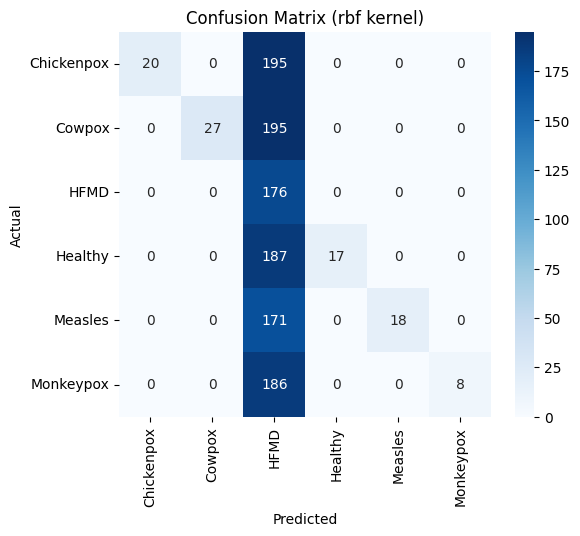

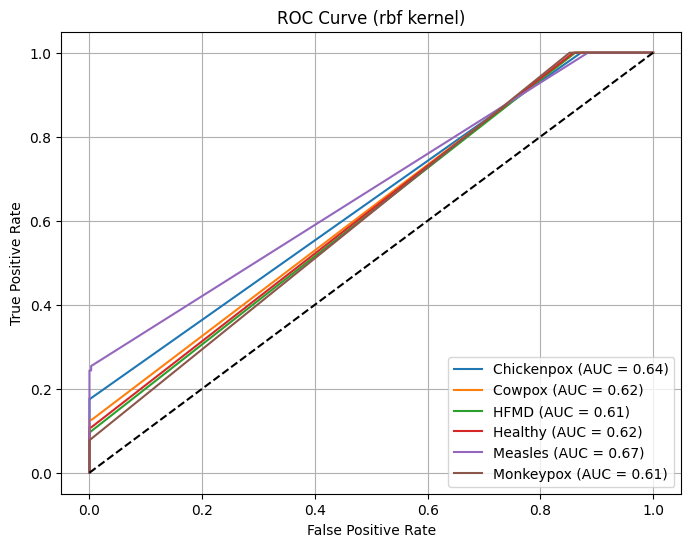


Training SVM with kernel = 'poly' | Params: {'degree': 3, 'coef0': 1}
Accuracy: 0.9267
              precision    recall  f1-score   support

  Chickenpox       0.91      0.89      0.90       215
      Cowpox       0.97      0.96      0.96       222
        HFMD       0.93      0.97      0.95       176
     Healthy       0.94      0.97      0.96       204
     Measles       0.94      0.93      0.93       189
   Monkeypox       0.87      0.85      0.86       194

    accuracy                           0.93      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.93      0.93      0.93      1200

AUC: 0.9943


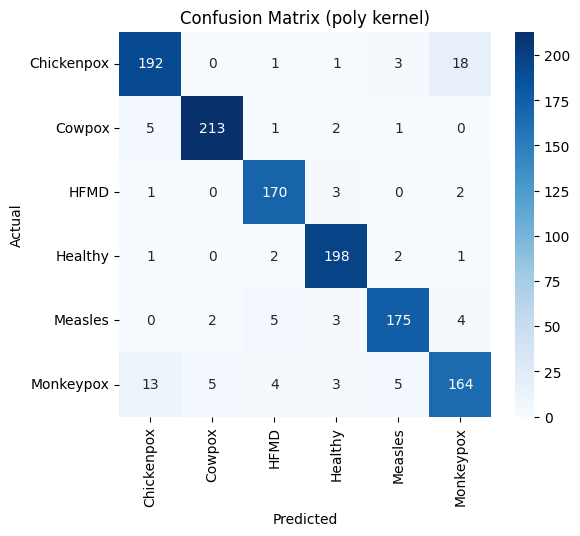

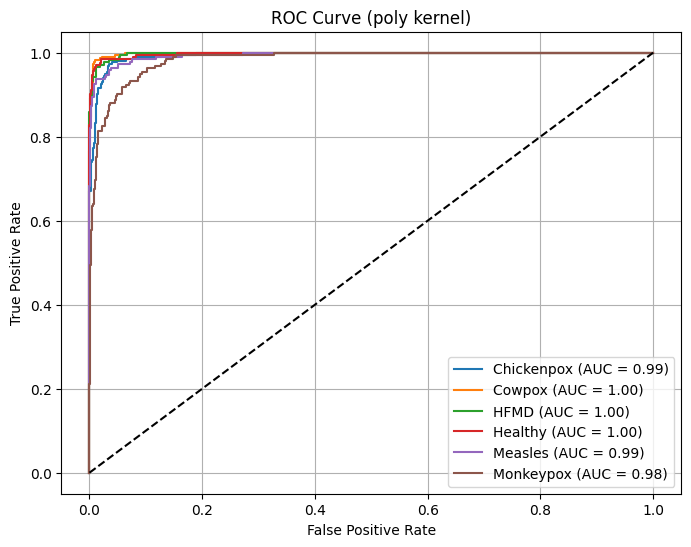

In [ ]:
# Example class names from train_generator
class_names = list(train_generator.class_indices.keys())

# Linear kernel
evaluate_svm_kernel(X_train, X_val, y_train, y_val,
                    kernel_type='linear',
                    kernel_params={},
                    class_names=class_names)

# RBF kernel
evaluate_svm_kernel(X_train, X_val, y_train, y_val,
                    kernel_type='rbf',
                    kernel_params={'gamma': 0.05},
                    class_names=class_names)

# Polynomial kernel
evaluate_svm_kernel(X_train, X_val, y_train, y_val,
                    kernel_type='poly',
                    kernel_params={'degree': 3, 'coef0': 1},
                    class_names=class_names)


# ANN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4684 - loss: 1.3641 - val_accuracy: 0.7908 - val_loss: 0.5789
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8208 - loss: 0.5267 - val_accuracy: 0.8542 - val_loss: 0.3988
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8943 - loss: 0.3225 - val_accuracy: 0.8883 - val_loss: 0.3046
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9419 - loss: 0.2022 - val_accuracy: 0.9100 - val_loss: 0.2610
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9551 - loss: 0.1496 - val_accuracy: 0.9092 - val_loss: 0.2365
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9673 - loss: 0.1123 - val_accuracy: 0.9017 - val_loss: 0.2531
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9749 - loss: 0.0864 - val_accuracy: 0.9158 - val_loss: 0.2238
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9861 - loss: 0.0569 - val_accurac

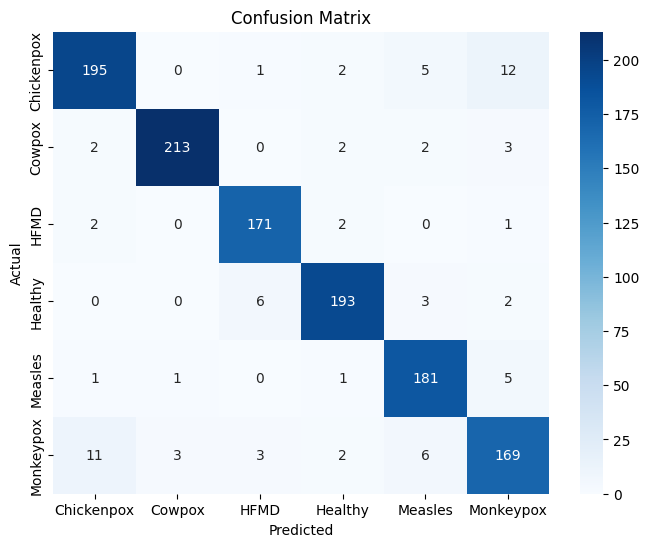

In [ ]:
from sklearn.model_selection import train_test_split # import the missing function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# load data files
X_features = np.load('/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train/X_features.npy')
y_labels = np.load('/content/drive/MyDrive/MonkeyPoxClassification_2025/skin_images/new_combined/final_balanced_train/y_labels.npy')

num_classes = 6

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_val, y_pred_classes, target_names=train_generator.class_indices.keys()))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

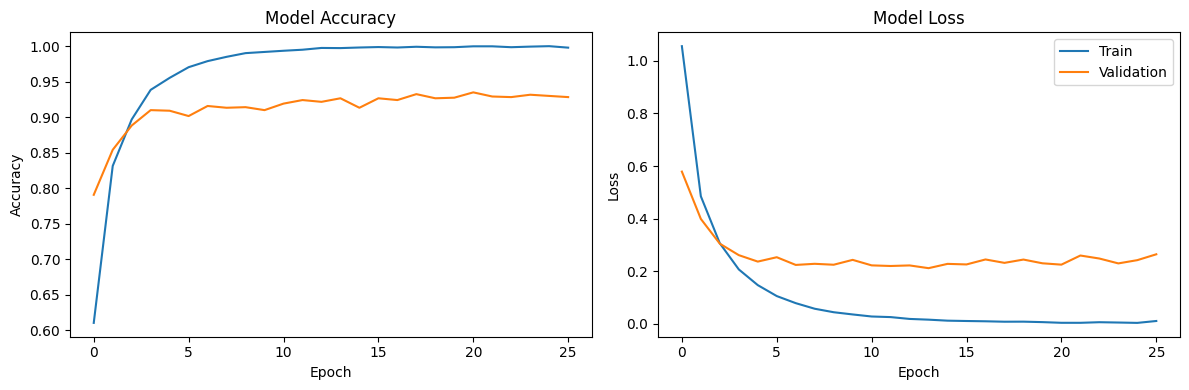

In [ ]:
# craete subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# plot acuuracy curve for subplot 1
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

# plot loss curves for subplot 2
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

plt.tight_layout()
plt.legend(['Train', 'Validation'])
plt.show()
